In [0]:
# !git clone https://github.com/midnightforever/urban/
# !rm -rf Urban/

In [2]:
import os 
os.chdir('/content/urban')
# os.chdir('/content')
os.getcwd()

'/content/urban'

In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="4"
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import variable_scope
plt.rcParams['figure.figsize'] = 16, 8
%tensorflow_version 1.x

In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
learning_rate = 0.001
total_epoch = 1000
batch_size = 64
dropout = 0.5
hidden_size = 20
index = 0

feed_train = {}
feed_val = {}
outputs = []
targets = []
DATAS = []
data_size = 6
datasets = {2: 'bareland', 3:'crop', 4:'forest', 5:'grass', 6:'rice', 7:'water'}

In [0]:
def dataplot(y_train, y_test, y_val):    
    from collections import Counter
    

    f, axes = plt.subplots(1, 3, figsize=(18, 6))
    ax1, ax2, ax3 = axes

    sns.countplot(y_train, ax=ax1)
    ax1.set_xlabel('train')
    ax1.set_ylabel('number')
    ax1.set_ylim([0, 2000])
    
    sns.countplot(y_val, ax=ax2)
    ax2.set_xlabel('val')
    ax2.set_ylabel('number')
    ax2.set_ylim([0, 2000])

    sns.countplot(y_test, ax=ax3)
    ax3.set_xlabel('test')
    ax3.set_ylabel('number')
    ax3.set_ylim([0, 2000])
    plt.show()

def customized_rnn_seq2seq(encoder_inputs, decoder_inputs, cell, dtype=dtypes.float32, scope=None):
    with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
        enc_cell = copy.deepcopy(cell)
        encoder_outputs, enc_state = tf.contrib.rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
    return customized_rnn_decoder(encoder_outputs, decoder_inputs, enc_state, cell)
  
def customized_rnn_decoder(encoder_outputs, decoder_inputs, initial_state, cell, loop_function=None, scope=None):
    with variable_scope.variable_scope(scope or "rnn_decoder"):
        state = initial_state
        outputs = []
        prev = None
        for i, inp in enumerate(decoder_inputs):
            if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                    inp = loop_function(prev, i)
            if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
            output, state = cell(inp, state)
            outputs.append(output)
            if loop_function is not None:
                prev = output
    return encoder_outputs, outputs, state

def data_maker():
    from collections import Counter
    data_train = np.loadtxt('train.txt', delimiter=',')
    data_test = np.loadtxt('test.txt', delimiter=',')
    dataholder = np.concatenate((data_train, data_test), axis=0)
    
    X_data = dataholder[:, 1:]
    y_data = dataholder[:, :1] - 2 
    y_data = y_data.reshape(y_data.shape[0]).tolist()
    # print(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1, stratify=y_data)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)
    
    c1 = Counter(y_train)
    c2 = Counter(y_test)
    c3 = Counter(y_val)
    print('train',c1) 
    print('test',c2) 
    print('val',c3)
    # print(len(y_train))
    # print(len(y_val))
    # print(len(y_test))
    dataplot(y_train, y_test, y_val)

    return X_train, y_train, X_val, y_val, X_test, y_test

def seq2seq_maker(index=1):
    X_train, y_train, X_val, y_val, X_test, y_test = data_maker()
    
    encoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]]) 
    decoder_input = tf.placeholder(tf.float32, [None, X_train.shape[1]])
    target = tf.placeholder(tf.int64, [None])

    targets.append(target)
    
    with tf.variable_scope("rnn_" + str(index)):
        cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=0.5)
        #output, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_input], [decoder_input], cell)
        en_outputs, de_outputs, state = customized_rnn_seq2seq([encoder_input], [decoder_input], cell)
        #print("encoder_outputs", encoder_outputs)
        #print("decoder_outputs", decoder_outputs)
        de_outputs = tf.reshape(de_outputs, [-1, hidden_size]) #3D -> 2D
        outputs.append(de_outputs)
    
    feed_train[encoder_input] = X_train
    feed_train[decoder_input] = X_train
    feed_train[target] = y_train
    
    feed_val[encoder_input] = X_val
    feed_val[decoder_input] = X_val
    feed_val[target] = y_val

train Counter({2.0: 1910, 4.0: 1700, 1.0: 1273, 5.0: 891, 3.0: 502, 0.0: 135})
test Counter({2.0: 531, 4.0: 472, 1.0: 354, 5.0: 248, 3.0: 139, 0.0: 37})
val Counter({2.0: 212, 4.0: 189, 1.0: 142, 5.0: 99, 3.0: 56, 0.0: 15})


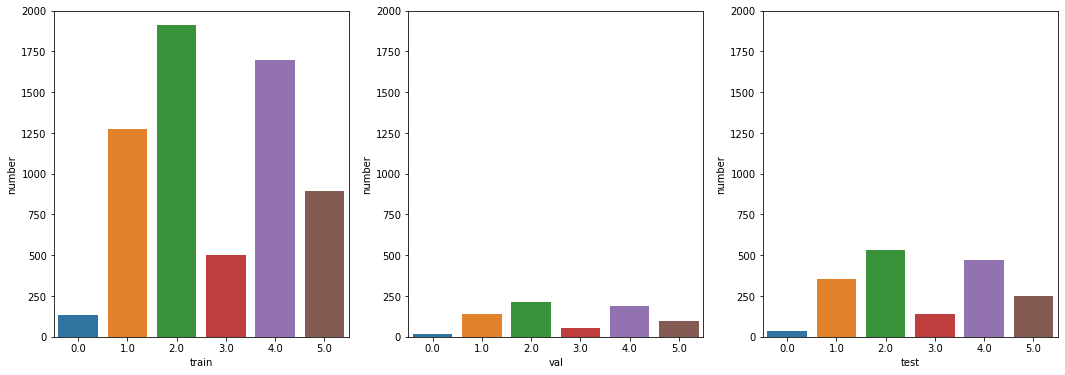

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
seq2seq_maker()

In [8]:
W = tf.Variable(tf.random_normal([hidden_size, 100]), name="W") 
b = tf.Variable(tf.random_normal([100]), name="b")
print("W", W)
print("b", b)
logits = [tf.matmul(output, W) + b for output in outputs]

with tf.variable_scope("cost"):
    loss = []
    for logit, target in zip(logits, targets):
        loss.append(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=target))
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 
    
#with tf.variable_scope("eval"):
#    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
#    correct_prediction = tf.equal(prediction, targets) #one-hot을 안쓰면 target에는 argmax할 필요없음
#    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W <tf.Variable 'W:0' shape=(20, 100) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(100,) dtype=float32_ref>


[[-0.60350156 -0.38691214  0.7561203  ... -0.35667068  0.35105112
   0.4374432 ]
 [ 0.2529312  -1.9613959  -1.6787497  ... -0.65792894  1.7830799
   0.899659  ]
 [ 0.32490525 -0.9021842  -0.02634702 ...  1.3722966  -0.4042658
   0.90747213]
 ...
 [ 1.7666767  -1.2483937   0.7708734  ...  1.571852   -0.5574694
  -0.17575318]
 [ 0.35706872  1.1787695   1.5761065  ...  1.2773248  -0.20737572
  -1.214323  ]
 [-0.524111   -0.23854151 -0.4773052  ...  1.2770705   1.226497
   1.0986274 ]]
[-5.3908688e-01 -3.6625275e-01  4.7464165e-01  7.9219043e-01
  1.9891549e+00  8.0540258e-01  6.6885650e-01 -1.4659922e-01
  9.9400264e-01  1.1100429e+00  1.1713843e+00 -5.8140755e-01
  5.9684652e-01  2.8604656e-01 -1.7912146e+00 -1.1308169e+00
  6.3723546e-01  1.6111888e-01  1.9838984e-01 -5.3721786e-01
 -5.5481201e-01 -8.3530462e-01 -1.2063411e+00  6.9869339e-01
  1.6345368e-01 -1.8750100e-01 -4.0604081e-02  1.0475937e+00
  8.1848359e-01  5.8797896e-01  5.9991688e-01  3.8076624e-01
 -9.1578150e-01  5.571315

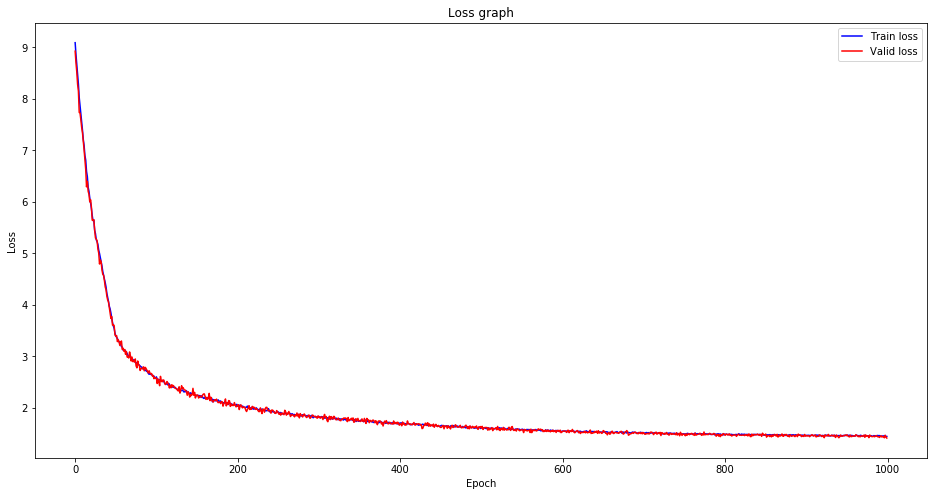

[[-0.55694216 -0.8539011  -0.15263036 ...  0.20285913  1.2785035
   1.5274671 ]
 [-0.16684881 -2.1276472  -1.9602917  ... -0.1710222   2.575864
   1.8616866 ]
 [ 0.6644017   0.77148116  0.77908283 ...  0.32235637 -1.3154823
  -0.43090805]
 ...
 [ 1.6503158  -1.2329303   0.68244934 ...  1.5956483  -0.39810082
   0.09754728]
 [ 0.9100397   1.530417    1.5967796  ...  0.6667849  -0.8971741
  -2.2932875 ]
 [-0.6010919  -0.50284696 -0.4805464  ...  0.9211418   0.88575387
   0.26183185]]
[-0.06486662  0.7058265   1.3095689   1.2562718   2.4924684   1.5432986
 -0.22008184 -0.6586523   0.12197381  0.36496425  0.31730983 -1.1475421
 -0.19376592 -0.53450626 -2.8089123  -1.945932   -0.14840636 -0.8911869
 -0.6071836  -1.5767542  -1.4111243  -1.625586   -2.153288   -0.33341676
 -0.28797817 -1.1407776  -0.51988274  0.43210474 -0.28055704 -0.2944588
  0.21215862 -0.42253315 -1.7552209  -0.2421954  -0.3518249  -2.8733912
 -1.4498942  -1.4445864  -1.2801584  -0.74811554 -1.7970157  -2.0235355
 -1.8698

In [9]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("============================sess init")
    start_time = time.time()
    train_losses = []
    valid_losses = []

    for epoch in range(total_epoch):
        _, train_loss = sess.run([optimizer, cost], feed_dict = feed_train)
        _, val_loss = sess.run([optimizer, cost], feed_dict = feed_val)
        train_losses += [train_loss]
        valid_losses += [val_loss]
        if epoch % 100 == 0:  
            print("Epoch {}/{} took {:.3f}s".format(epoch + 1, total_epoch, time.time() - start_time))
            print("  Train      loss : %.6f" % (train_losses[epoch]))
            print("  Validation loss : %.6f" % (valid_losses[epoch]))
    print("It took", time.time() - start_time, "seconds to train for", total_epoch, "epochs.")        
    print("============================ training end")
    
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(valid_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    #print('Accuracy:', sess.run(accuracy_op, feed_dict=feed_dict))
    #pred = sess.run(prediction, feed_dict=feed_dict)
    #for p, i in zip(pred, y_test.flatten()):
    #    print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))
        
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    save_path = saver.save(sess, "./weights.ckpt")
    print("model saved!")

In [0]:
tf.reset_default_graph()
saver = tf.train.import_meta_graph("./weights.ckpt.meta")

train Counter({2.0: 1910, 4.0: 1700, 1.0: 1273, 5.0: 891, 3.0: 502, 0.0: 135})
test Counter({2.0: 531, 4.0: 472, 1.0: 354, 5.0: 248, 3.0: 139, 0.0: 37})
val Counter({2.0: 212, 4.0: 189, 1.0: 142, 5.0: 99, 3.0: 56, 0.0: 15})


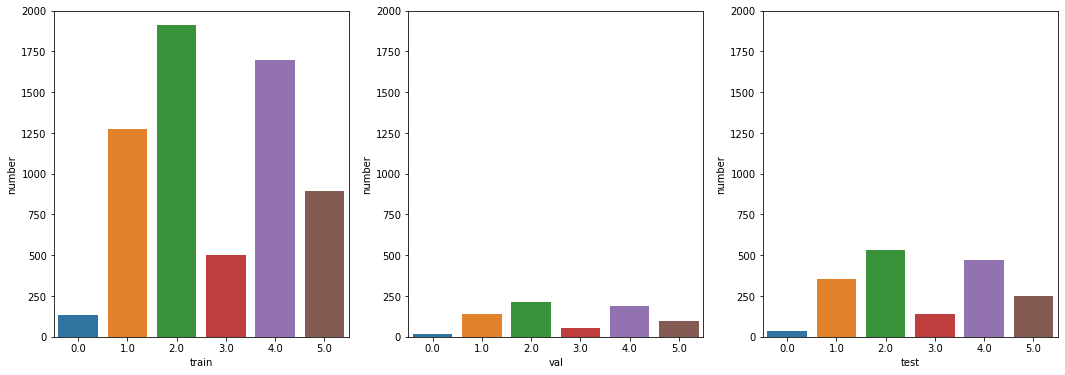

outputs Tensor("seq2seq/Reshape:0", shape=(?, 20), dtype=float32)
W Tensor("W:0", shape=(20, 100), dtype=float32_ref)
b Tensor("b:0", shape=(100,), dtype=float32_ref)


In [11]:
learning_rate = 0.001
total_epoch = 1000
batch_size = 64
dropout = 0.5
# hidden_size = 200
index = 0

n_variable = 2

encoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="encoder_inputs") 
decoder_inputs = tf.placeholder(tf.float32, [None, n_variable], name="decoder_inputs")
targets = tf.placeholder(tf.int64, [None], name="targets")

X_train, y_train, X_val, y_val, X_test, y_test = data_maker()

with tf.variable_scope("seq2seq"):  
    cell = tf.contrib.rnn.GRUCell(num_units=hidden_size)
    outputs, states = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq([encoder_inputs], [decoder_inputs], cell)
    outputs = tf.reshape(outputs, [-1, hidden_size]) #3D -> 2D
    print("outputs", outputs)  # output 모양이 항상 [? , hidden_size]으로 고정됨

    W = tf.get_default_graph().get_tensor_by_name("W:0")
    b = tf.get_default_graph().get_tensor_by_name("b:0")
    print("W", W)
    print("b", b)
    logits = tf.matmul(outputs, W) + b

with tf.variable_scope("cost_2"):
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

with tf.variable_scope("eval_2"):
    prediction = tf.argmax(tf.nn.softmax(logits), 1) 
    correct_prediction = tf.equal(prediction, targets) #one-hot을 안쓰면 target에는 argmax할 필요없음
    accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

INFO:tensorflow:Restoring parameters from ./weights.ckpt
... check point loaded
[[-0.55694216 -0.8539011  -0.15263036 ...  0.20285913  1.2785035
   1.5274671 ]
 [-0.16684881 -2.1276472  -1.9602917  ... -0.1710222   2.575864
   1.8616866 ]
 [ 0.6644017   0.77148116  0.77908283 ...  0.32235637 -1.3154823
  -0.43090805]
 ...
 [ 1.6503158  -1.2329303   0.68244934 ...  1.5956483  -0.39810082
   0.09754728]
 [ 0.9100397   1.530417    1.5967796  ...  0.6667849  -0.8971741
  -2.2932875 ]
 [-0.6010919  -0.50284696 -0.4805464  ...  0.9211418   0.88575387
   0.26183185]]
[-0.06486662  0.7058265   1.3095689   1.2562718   2.4924684   1.5432986
 -0.22008184 -0.6586523   0.12197381  0.36496425  0.31730983 -1.1475421
 -0.19376592 -0.53450626 -2.8089123  -1.945932   -0.14840636 -0.8911869
 -0.6071836  -1.5767542  -1.4111243  -1.625586   -2.153288   -0.33341676
 -0.28797817 -1.1407776  -0.51988274  0.43210474 -0.28055704 -0.2944588
  0.21215862 -0.42253315 -1.7552209  -0.2421954  -0.3518249  -2.8733912


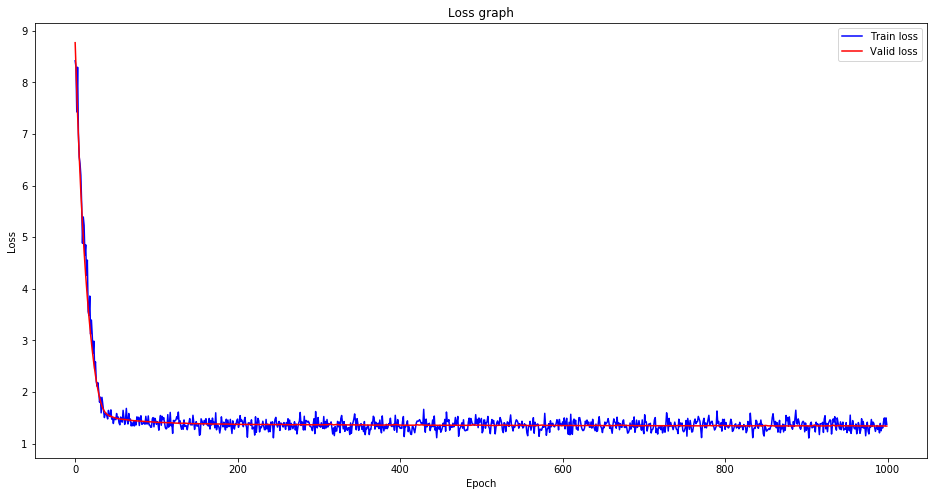

In [12]:
train_losses = []
val_losses = []
new_saver = tf.train.Saver()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "./weights.ckpt")
    print("... check point loaded")
    print(sess.run("W:0"))
    print(sess.run("b:0"))
    print("=============================== training")
    start_time = time.time()

    for epoch in range(total_epoch):
        batch_mask = np.random.choice(len(X_train), batch_size)
        # print(batch_mask)
        X_batch = X_train[batch_mask]
        y_batch = np.array(y_train)[batch_mask]
        y_batch = y_batch.tolist()
        # Compute the losses
        _, tr_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_batch, decoder_inputs: X_batch, targets: y_batch})
        _, val_loss = sess.run([optimizer, cost], feed_dict={encoder_inputs: X_val, decoder_inputs: X_val, targets: y_val})
        # Log the losses
        train_losses += [tr_loss]
        val_losses += [val_loss]
  
        if epoch % 100 == 0:  
            print("Epoch {}/1000 took {:.3f}s".format(epoch + 1, time.time() - start_time))
            print("  Train loss : %.6f"%(train_losses[epoch]))
            print("  valid loss : %.6f"%(val_losses[epoch]))

    print("============================ training end")
    print('Accuracy:', sess.run(accuracy_op, feed_dict={encoder_inputs: X_test, decoder_inputs: X_test, targets: y_test}))
    
    plt.plot(train_losses, '-b', label='Train loss')
    plt.plot(val_losses, '-r', label='Valid loss')
    plt.legend(loc=0)
    plt.title('Loss graph')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    pred = sess.run(prediction, feed_dict={encoder_inputs: X_test, decoder_inputs: X_test})
    # for p, i in zip(pred, y_test):
    #     print("[{}] Prediction: {} True Y: {}".format(p == int(i), p, int(i)))
    

              precision    recall  f1-score   support

    bareland       0.00      0.00      0.00        37
        crop       1.00      0.00      0.01       354
      forest       0.37      0.62      0.47       531
       grass       0.00      0.00      0.00       139
        rice       0.33      0.41      0.37       472
       water       0.64      0.81      0.72       248

    accuracy                           0.41      1781
   macro avg       0.39      0.31      0.26      1781
weighted avg       0.49      0.41      0.34      1781

[[  0   0  18   0  16   3]
 [  0   1 198   0 146   9]
 [  0   0 328   0 169  34]
 [  0   0  79   0  40  20]
 [  0   0 231   0 194  47]
 [  0   0  24   0  22 202]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


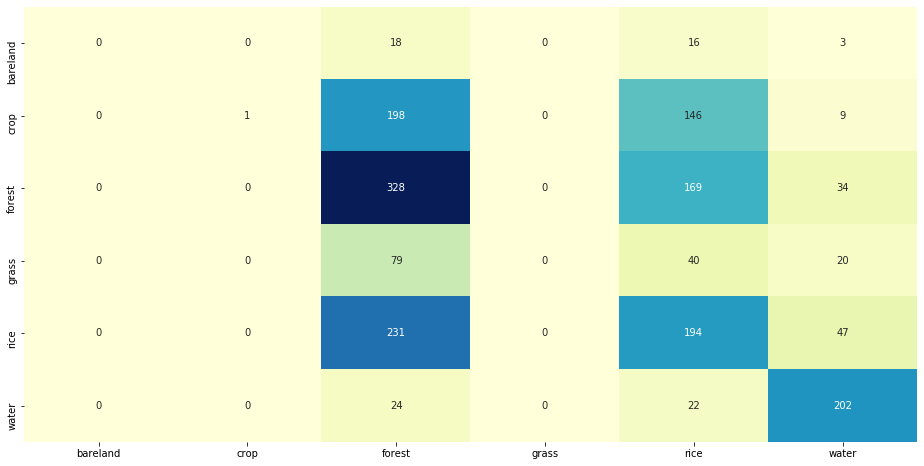

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
# pred = sess.run(prediction, feed_dict={encoder_inputs: X_test, decoder_inputs: X_test})
target_names = ['bareland', 'crop', 'forest', 'grass', 'rice', 'water']
matrix = confusion_matrix(np.array(y_test), np.array(pred))
df = pd.DataFrame(matrix, index = [i for i in target_names], columns = [i for i in target_names])
fig = plt.figure(figsize = (16,8))
sns.heatmap(df, annot=True, cbar=False, cmap="YlGnBu", fmt='d')
plt.savefig('matrix')
report = classification_report(y_test, pred, target_names=target_names)
print(report)
print(matrix)